# Graph 

In [1]:
from __future__ import print_function
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; } </style>"))
import matplotlib.pyplot as plt

In [2]:
from pkg.marker_config import *
init_kinect()
cameraMatrix, distCoeffs = get_calibration()
aruco_map, dictionary = get_aruco_config()

Device configuration: 
	color_format: 3 
	(0:JPG, 1:NV12, 2:YUY2, 3:BGRA32)

	color_resolution: 5 
	(0:OFF, 1:720p, 2:1080p, 3:1440p, 4:1536p, 5:2160p, 6:3072p)

	depth_mode: 3 
	(0:OFF, 1:NFOV_2X2BINNED, 2:NFOV_UNBINNED,3:WFOV_2X2BINNED, 4:WFOV_UNBINNED, 5:Passive IR)

	camera_fps: 2 
	(0:5 FPS, 1:15 FPS, 2:30 FPS)

	synchronized_images_only: False 
	(True of False). Drop images if the color and depth are not synchronized

	depth_delay_off_color_usec: 0 ms. 
	Delay between the color image and the depth image

	wired_sync_mode: 0
	(0:Standalone mode, 1:Master mode, 2:Subordinate mode)

	subordinate_delay_off_master_usec: 0 ms.
	The external synchronization timing.

	disable_streaming_indicator: False 
	(True or False). Streaming indicator automatically turns on when the color or depth camera's are in use.




In [3]:
color_image = get_kinect_image()
objectPose_dict, corner_dict = get_object_pose_dict(color_image, aruco_map, dictionary, cameraMatrix, distCoeffs)
color_image_out = draw_objects(color_image, aruco_map, objectPose_dict, corner_dict, cameraMatrix, distCoeffs, axis_len=0.1)

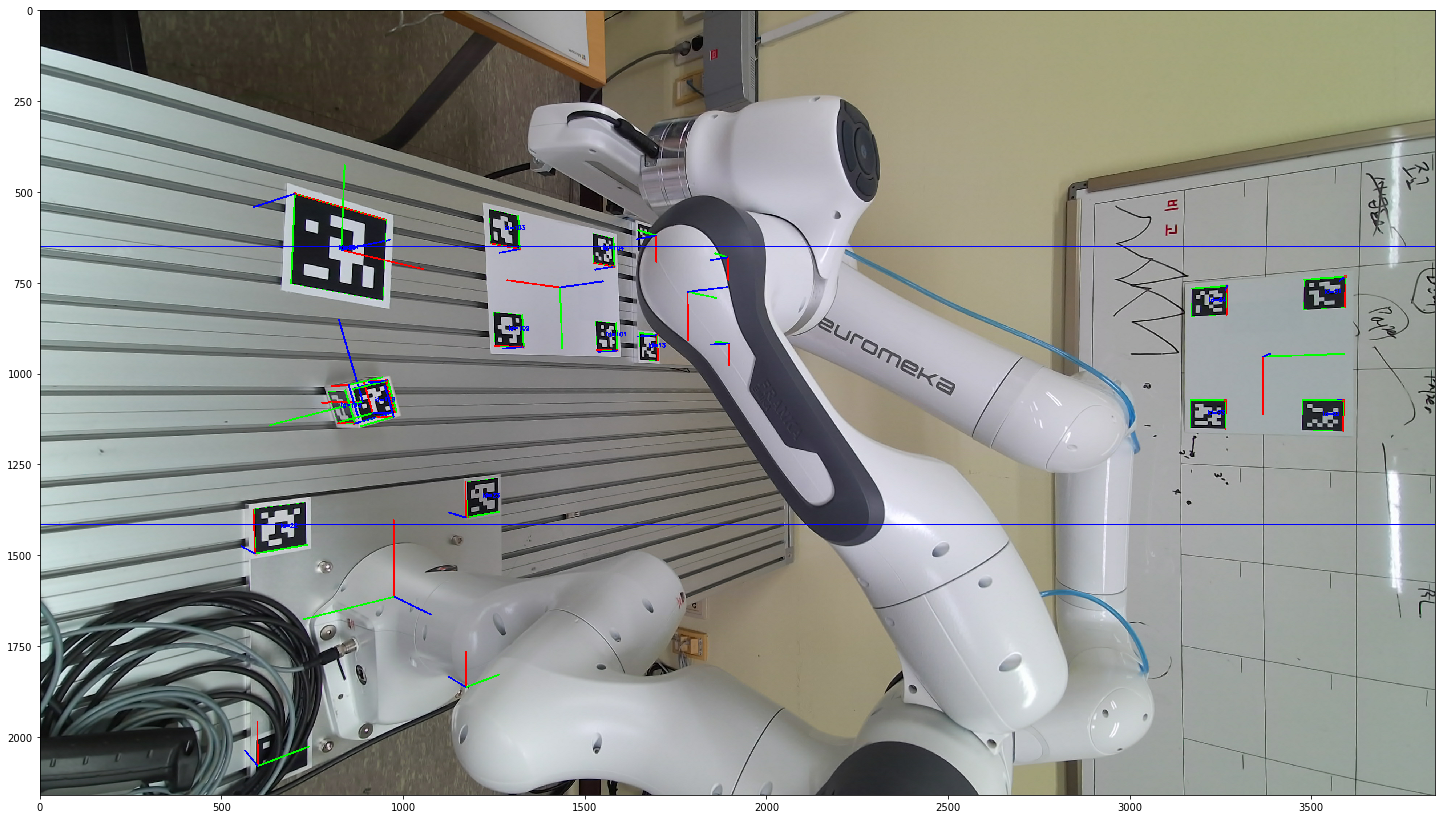

In [4]:
plt.figure(figsize=(25,15))
plt.imshow(color_image_out[:,:,[2,1,0]])

In [5]:
disconnect_kinect()

In [26]:
xyz_indy0, rpy_indy0 = T2xyzrpy(get_T_rel('floor', 'indy0', objectPose_dict))
xyz_panda1, rpy_panda1 = T2xyzrpy(get_T_rel('floor', 'panda1', objectPose_dict))
T_bo_0 = get_T_rel('floor', 'box1', objectPose_dict)
xyz_box1, rvec_box1 = T2xyzrvec(T_bo_0)
xyz_goal, rvec_goal = T2xyzrvec(get_T_rel('floor', 'goal', objectPose_dict))
xyz_wall, rvec_wall = T2xyzrvec(get_T_rel('floor', 'wall', objectPose_dict))

In [7]:
urdf_content = None
from pkg.robots_custom import *
xcustom = XacroCustomizer()
xcustom.clear()
# xcustom.add_robot(RobotType.indy7_robot, xyz=[0,-0.5,0], rpy=[0,0,0])
# xcustom.add_robot(RobotType.panda_robot, xyz=[0,0.5,0], rpy=[0,0,0])
xcustom.add_robot(RobotType.indy7_robot, xyz=xyz_indy0, rpy=rpy_indy0)
xcustom.add_robot(RobotType.panda_robot, xyz=xyz_panda1, rpy=rpy_panda1)
xcustom.write_xacro()
vel_scale = 1.0/2.0
JOINT_NAMES, LINK_NAMES, ZERO_JOINT_POSE, urdf_content = \
        xcustom.convert_xacro_to_urdf(
        joint_fix_dict={'finger':'upper'},
        vel_limit_dict={k: v*vel_scale for k,v in {
            'panda1_joint1': np.deg2rad(150),  'panda1_joint2': np.deg2rad(150), 
            'panda1_joint3': np.deg2rad(150), 'panda1_joint4': np.deg2rad(150), 
            'panda1_joint5': np.deg2rad(180), 'panda1_joint6': np.deg2rad(180), 'panda1_joint7': np.deg2rad(180), 
            'indy0_joint0': np.deg2rad(150), 'indy0_joint1': np.deg2rad(150), 'indy0_joint2': np.deg2rad(150), 
            'indy0_joint3': np.deg2rad(180), 'indy0_joint4': np.deg2rad(180), 'indy0_joint5': np.deg2rad(180), 
        }.items()}
    )
ZERO_JOINT_POSE=np.array([0,0,-np.pi/2,0,-np.pi/2,0,
                          0,-np.pi/8,0,-np.pi/2,0,np.pi/2,0])
refine_meshes()
xcustom.start_rviz()
    
from pkg.constraint_graph import *
from pkg.constants import *
import matplotlib.pyplot as plt
from pkg.plot_utils import *
from pkg.utils import *
# from threading import Thread, Lock
from multiprocessing import Process, Lock, Manager
PROC_MODE = True
rospy.init_node('task_planner', anonymous=True)

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


In [8]:
gtimer = GlobalTimer.instance()
gtimer.reset()
graph = ConstraintGraph(urdf_path=URDF_PATH, joint_names=JOINT_NAMES, link_names=LINK_NAMES, urdf_content=urdf_content,
                       connect_robots = False)
col_items_dict = graph.set_fixed_geometry_items(
    get_geometry_items_dict(graph.urdf_content, color=(0,1,0,0.5), display=True, collision=True, 
                             exclude_link=["panda1_link7"]))

# Custom Robots

In [9]:
gtimer.tic("set_scene")
collision=True
graph.add_geometry_items("world", 
                         [
                           GeoMesh(uri="package://my_mesh/meshes/stl/end_tool_asm_ctd.stl", BLH=(0.01,0.01,0.01), scale=(1e-3,1e-3,1e-3), name="gripper1", link_name="indy0_tcp", 
                                   urdf_content=graph.urdf_content, color=(0.1,0.1,0.1,1), collision=False),
                           GeoBox((-0.055, 0,0.012), (0.05,0.05,0.07), name="gripper1_col", link_name="indy0_tcp", urdf_content=graph.urdf_content, color=(0,1,0,0.5), collision=collision),
                           GeoBox((0,0,-0.005), (3,3,0.01), name="floor", link_name="world", urdf_content=graph.urdf_content, color=(0.6,0.6,0.6,1), collision=collision),
                           GeoBox(xyz_wall, (3,3,0.01),orientation=rvec_wall, name="wall", link_name="world", urdf_content=graph.urdf_content, color=(0.6,0.6,0.6,1), collision=collision),
#                            GeoBox((0.4,0.4,0.15), (0.15,0.15,0.3), name="stepper", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1), collision=collision),
                           GeoBox(xyz_goal, (0.1,0.1,1e-3),orientation=rvec_goal, name="goal_disp", link_name="world", urdf_content=graph.urdf_content, color=(0.8,0.0,0.0,1), collision=False)],
                         fixed=True)

graph.add_geometry_items("world", 
                         [GeoBox(xyz_box1, (0.05,0.05,0.05),orientation=rvec_box1, name="box1", link_name="world", urdf_content=graph.urdf_content, color=(0.3,0.3,0.8,1), collision=collision)],
                         fixed=False)

graph.register_binder(name='grip1', _type=VacuumTool, point=[0,-2.5e-2,11e-2], link_name="panda1_hand", direction=[0,1,0])
graph.register_binder(name='vac2', _type=VacuumTool, point=[0,0,5e-2], link_name="indy0_tcp", direction=[0,0,1])
graph.register_binder(name='floor', _type=PlacePlane, direction=[0,0,1])
graph.register_binder(name='goal', _type=PlaceFrame, point=xyz_goal, orientation=rvec_goal, link_name="world")

box1_put_point = get_put_dir(Robj=Rotation.from_rotvec(rvec_box1).as_dcm(), dir_vec_dict=dir_vec_dict)+"_p"
graph.register_object('box1', _type=BoxAction, binding=(box1_put_point,"floor"), hexahedral=True)

graph.build_graph()
gtimer.toc("set_scene")
print("put_point: {}".format(box1_put_point))

# Set RVIZ

In [11]:
gtimer.tic("set_sim")
graph.set_simulation(nWSR=50, regularization_factor= 1e-1)
gtimer.toc("set_sim")
# graph.show_pose(ZERO_JOINT_POSE, execute=True)

Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


# Search Graph (Custom Robots)

In [27]:
graph.set_object_state(State((('box1',box1_put_point,'floor'),), {'box1': T_bo_0}, None))

In [28]:
gtimer.reset()
initial_state = State(*(graph.get_object_state()+(ZERO_JOINT_POSE,)))
goal_state = State((('box1',box1_put_point.replace('_p', '_f'),'goal'),), None, None)
graph.search_graph_mp(
    initial_state = initial_state, goal_state = goal_state,
    tree_margin = 4, depth_margin = 2, joint_motion_num=10, 
    terminate_on_first = True, N_search = 100, N_loop=1000,
    display=False, dt_vis=1e-3, verbose = True, print_expression=False,
    **dict(N=300, dt=0.025, vel_conv=1e-2, err_conv=1e-3, N_step=300))


success - Goal cost:2->1 / Init cost:0->1 / branching: 0->1 (0.35 s)
node: (('box1', 'right_p', 'floor'),)->(('box1', 'back_p', 'grip1'),)

success - Goal cost:2->1 / Init cost:0->1 / branching: 0->2 (0.5 s)
node: (('box1', 'right_p', 'floor'),)->(('box1', 'bottom_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (0.59 s)
node: (('box1', 'right_p', 'floor'),)->(('box1', 'front_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (0.68 s)

success - Goal cost:1->0 / Init cost:1->2 / branching: 1->3 (0.68 s)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (0.68 s)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (0.7 s)node: (('box1', 'right_p', 'floor'),)->(('box1', 'back_p', 'vac2'),)

node: (('box1', 'back_p', 'grip1'),)->(('box1', 'right_f', 'goal'),)

node: (('box1', 'right_p', 'floor'),)->(('box1', 'left_p', 'vac2'),)
node: (('box1', 'right_p', 'floor'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->

In [29]:
print(gtimer)

get_object_state: 	1.0 ms/1 = 0.617 ms 
search_graph_mp: 	1061.0 ms/1 = 1061.405 ms 
init_search: 	3.0 ms/1 = 3.492 ms 
score_graph: 	1.0 ms/2 = 0.665 ms 
reset_valid_node: 	1.0 ms/233 = 0.003 ms 
get_valid_neighbor: 	0.0 ms/23 = 0.017 ms 
add_node_queue_leafs: 	3.0 ms/1 = 2.893 ms 



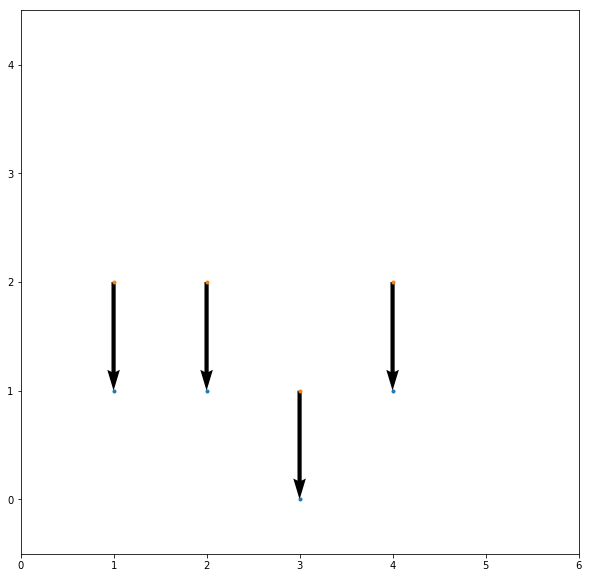

In [30]:
graph.quiver_snodes()

# Replay schedule

In [31]:
schedule_dict = graph.find_schedules()
schedule_sorted = graph.sort_schedule(schedule_dict)
for schedule in schedule_sorted:
    print(schedule)
for schedule, i_s in zip(schedule_sorted, range(len(schedule_sorted))):
    e, end_state, success = graph.simulate_transition(graph.snode_dict[0].state, graph.snode_dict[0].state, N=10, dt=0.01, vel_conv=1e-2, err_conv=5e-4)
    timer.sleep(1)
#     try:
    e = graph.replay(schedule, N=300, dt=0.01, N_step=10, vel_conv=1e-2, err_conv=5e-4)
#     except Exception as e:
#         print(e)

[0, 1, 3]

--------------------
1-(('box1', 'back_p', 'grip1'),)

--------------------
3-(('box1', 'right_f', 'goal'),)


In [47]:
gtimer.reset()

In [48]:
graph.execute_schedule(schedule, dt=0.01, dt_exec=0.05)

In [46]:
print(graph.gtimer)

execute_schedule: 	15172.0 ms/1 = 15172.306 ms 
execute_transition: 	15170.0 ms/3 = 5056.695 ms 
get_transition_context: 	4.0 ms/3 = 1.218 ms 
set_object_state: 	1.0 ms/3 = 0.398 ms 
start get_tf_text: 	2.0 ms/3 = 0.575 ms 
start get_collision_text: 	0.0 ms/3 = 0.119 ms 
start make_constraints: 	0.0 ms/3 = 0.061 ms 
execute_step: 	14924.0 ms/733 = 20.36 ms 
update: 	850.0 ms/730 = 1.164 ms 
execute_pose: 	360.0 ms/733 = 0.491 ms 
move_indy: 	6630.0 ms/466 = 14.228 ms 
set occupied: 	1.0 ms/466 = 0.002 ms 
amovej: 	6623.0 ms/466 = 14.212 ms 
set free: 	1.0 ms/466 = 0.001 ms 
execute_grip: 	1.0 ms/3 = 0.275 ms 



In [39]:
blending_type(BlendingType.OVERRIDE)

In [40]:
gtimer.reset()
qval = np.array([0]*6)
jvel = JointMotionVel(graph.indy_speed,graph.indy_speed)
for i in range(90):
    gtimer.tic("jpose")
    jpos = JointPos(*(qval+float(min(i,45))))
    gtimer.toc("jpose")
    gtimer.tic("amovej-{}".format(i))
    amovej(jpos,
           jv=jvel)
    gtimer.toc("amovej-{}".format(i))
    timer.sleep(0.01)

In [41]:
print(gtimer)

jpose: 	4.0 ms/90 = 0.046 ms 
amovej-0: 	2.0 ms/1 = 1.959 ms 
amovej-1: 	2.0 ms/1 = 1.979 ms 
amovej-2: 	26.0 ms/1 = 26.439 ms 
amovej-3: 	99.0 ms/1 = 99.267 ms 
amovej-4: 	299.0 ms/1 = 299.196 ms 
amovej-5: 	500.0 ms/1 = 499.868 ms 
amovej-6: 	145.0 ms/1 = 145.229 ms 
amovej-7: 	96.0 ms/1 = 96.042 ms 
amovej-8: 	145.0 ms/1 = 145.215 ms 
amovej-9: 	96.0 ms/1 = 96.086 ms 
amovej-10: 	145.0 ms/1 = 145.324 ms 
amovej-11: 	100.0 ms/1 = 99.705 ms 
amovej-12: 	149.0 ms/1 = 149.078 ms 
amovej-13: 	88.0 ms/1 = 88.149 ms 
amovej-14: 	146.0 ms/1 = 145.813 ms 
amovej-15: 	96.0 ms/1 = 95.533 ms 
amovej-16: 	146.0 ms/1 = 145.776 ms 
amovej-17: 	95.0 ms/1 = 95.299 ms 
amovej-18: 	145.0 ms/1 = 145.473 ms 
amovej-19: 	95.0 ms/1 = 94.636 ms 
amovej-20: 	146.0 ms/1 = 146.482 ms 
amovej-21: 	102.0 ms/1 = 102.192 ms 
amovej-22: 	139.0 ms/1 = 138.813 ms 
amovej-23: 	94.0 ms/1 = 94.419 ms 
amovej-24: 	147.0 ms/1 = 146.904 ms 
amovej-25: 	94.0 ms/1 = 94.052 ms 
amovej-26: 	147.0 ms/1 = 147.339 ms 
amovej-27:

In [14]:
import threading, time

def foo():
    rval = np.random.rand()
    timer.sleep(rval*5e-3)

dt = 1e-2
N = 300
count = 0
ts = timer.time()
t_vec = []
ticker = threading.Event()
while not ticker.wait(dt):
    if count > N:
        break
    count += 1
    t_vec.append(timer.time())
    foo()
    
dt_vec = np.subtract(t_vec[1:],t_vec[:-1])
print("{}-{}".format(np.mean(dt_vec), np.std(dt_vec)))

0.0128751571973-0.00152790885382


In [39]:
ts = timer.time()
count = 0
t_vec = []
def work (count): 
    count += 1
    if count < N:
        threading.Timer(dt, work, args=(count,)).start ()
    t_vec.append(timer.time())
    foo()

work (count)
timer.sleep(4)
dt_vec = np.subtract(t_vec[1:],t_vec[:-1])
print("{}-{}".format(np.mean(dt_vec), np.std(dt_vec)))

0.0105219501317-7.84038972934e-05


In [42]:
len(dt_vec)

299

In [36]:
N

300

In [ ]:
from pkg.etasl_control import *

In [ ]:
idx_sh = 0
from_state = graph.snode_dict[schedule[idx_sh]].state
to_state = graph.snode_dict[schedule[idx_sh+1]].state
full_context, pos_start, kwargs, binding_list = \
        graph.get_transition_context(from_state, to_state, vel_conv=1e-2, err_conv=5e-4, N=300, dt=0.01)
initialize_etasl_control(full_context, joint_names=JOINT_NAMES, zeros_pose=pos_start)
gtimer.reset()
for _ in range(300):
    gtimer.tic("update")
    joints_new = update_step(dt=1e-2)
    gtimer.toc("update")
    lib.etasl_getOutput("etasl", "output")
    print(lib.DoubleMap_get("output", "error"))
    
    graph.show_pose(np.array(joints_new))
    timer.sleep(1e-2)
print(gtimer)

In [42]:
np.sum(np.abs(np.subtract(to_state.Q, joints_new)))

0.08495756823646491

In [41]:
gtimer.reset()
print(gtimer)

conv: 	0.0 ms/1 = 0.209 ms 



0

0.0

In [36]:
print(full_context)


require("context")
require("geometric")
--require("libexpressiongraph_collision")
require("collision")
require("libexpressiongraph_velocities")
local u=UrdfExpr();
local fn = "/home/junsu/Projects/tf_gmt/eTaSL/robots/custom_robots.urdf"
u:readFromFile(fn)

margin=0.0001
radius=0.0
error_target=0
u:addTransform("T_world","world","world")
u:addTransform("T_indy0_link0","indy0_link0","world")
u:addTransform("T_indy0_link1","indy0_link1","world")
u:addTransform("T_indy0_link2","indy0_link2","world")
u:addTransform("T_indy0_link3","indy0_link3","world")
u:addTransform("T_indy0_link4","indy0_link4","world")
u:addTransform("T_indy0_link5","indy0_link5","world")
u:addTransform("T_indy0_link6","indy0_link6","world")
u:addTransform("T_indy0_tcp","indy0_tcp","world")
u:addTransform("T_panda1_link0","panda1_link0","world")
u:addTransform("T_panda1_link1","panda1_link1","world")
u:addTransform("T_panda1_link2","panda1_link2","world")
u:addTransform("T_panda1_link3","panda1_link3","world")
u:addTra

update: 	340.0 ms/300 = 1.135 ms 
show_pose: 	3645.0 ms/300 = 12.149 ms 



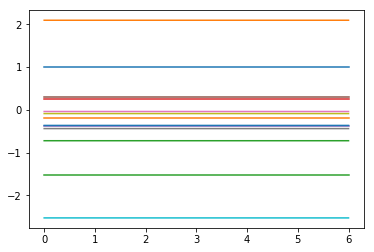

In [11]:
plt.plot(e.POS)

In [ ]:
# e = graph.replay(schedule, N=1500, dt=0.002, vel_conv=1e-2, err_conv=5e-3)

In [ ]:
ctems = [gtem for gtem in GeometryItem.GLOBAL_GEO_LIST if gtem.collision]
print(len(ctems))
for ctem in ctems:
    print(ctem.name)

In [11]:
e.displayContext()

# Test

In [12]:
N = 300
dt = 1e-2

from_state = State((('box1','bottom_p','floor'),), {'box1': [0.5,-0.3,0.05,0,0,0,1]}, ZERO_JOINT_POSE)
to_state = State((('box1', 'top_p', 'vac2'), ),None, None)

In [ ]:
self = graph

In [ ]:
gtimer = GlobalTimer.instance()
gtimer.tic("start set transition")
if from_state is not None:
    pos_start = from_state.Q
    self.set_object_state(from_state)

tf_col_text = get_tf_collision_text(GeometryItem.GLOBAL_GEO_LIST)

In [5]:
import os
from pkg.global_config import *

In [6]:
import ctypes

lib = ctypes.cdll.LoadLibrary(os.path.join(TF_GMT_ETASL_DIR, 'ws_ros/devel/lib/libetasl_ros_controllers.so'))
lib.etasl_create.argtypes = [ctypes.c_char_p, ctypes.c_double, ctypes.c_double, ctypes.c_double]
lib.DoubleMap_get.restype = ctypes.c_double

In [7]:
lib.etasl_create("etasl", 300,0.0,0.001)
context_text = np.load("ctx.npy")
lib.etasl_readTaskSpecification("etasl", context_text.tostring())
lib.DoubleMap_create("init_val")
lib.DoubleMap_create("conv_val")
lib.DoubleMap_create("input")
lib.DoubleMap_create("output")
lib.DoubleMap_create("joint_val")
lib.DoubleMap_create("joint_val_new")

In [8]:
for jname, jval in zip(JOINT_NAMES, ZERO_JOINT_POSE):
    lib.DoubleMap_set("init_val", jname, ctypes.c_double(jval))
    lib.DoubleMap_set("joint_val", jname, ctypes.c_double(jval))
lib.etasl_initialize("etasl", "init_val", 
                     ctypes.c_double(10.0), 
                     ctypes.c_double(0.004), 
                     ctypes.c_double(1E-4), "conv_val")
lib.etasl_setInput("etasl", "input")
joint_vals = []
for jname in JOINT_NAMES:
    joint_vals.append(lib.DoubleMap_get("joint_val", jname))
print(np.round(joint_vals,2))
lib.etasl_setJointPos("etasl", "joint_val")
joint_vals = []
for jname in JOINT_NAMES:
    joint_vals.append(lib.DoubleMap_get("joint_val", jname))
print(np.round(joint_vals,2))

0

In [29]:
gtimer.reset()
for _ in range(100):
    gtimer.tic("step")
    lib.etasl_updateStep("etasl", ctypes.c_double(1e-2))
    lib.etasl_getJointPos("etasl", "joint_val_new")
    joint_vals = []
    for jname in JOINT_NAMES:
        joint_vals.append(lib.DoubleMap_get("joint_val_new", jname))
    gtimer.toc("step")
print(np.round(joint_vals,2))
print(gtimer)

[ 0.73 -0.73 -1.78 -0.   -0.63  0.    0.   -0.39  0.   -1.57 -0.    1.57
 -0.  ]
step: 	81.0 ms/100 = 0.808 ms 



In [7]:
N = 300
dt = 1e-2

from_state = State((('box1','bottom_p','floor'),), {'box1': SE3(np.identity(3), [0.5,-0.3,0.05])}, ZERO_JOINT_POSE)
to_state = State((('box1', 'top_p', 'vac2'), ),None, None)


e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True, print_expression=True, N=N, dt=dt, vel_conv=1e-2, err_conv=1e-3)
print(succ)
end_state_bak = end_state.copy()


require("context")
require("geometric")
--require("libexpressiongraph_collision")
require("collision")
require("libexpressiongraph_velocities")
local u=UrdfExpr();
local fn = "/home/junsu/Projects/tf_gmt/eTaSL/robots/custom_robots.urdf"
u:readFromFile(fn)

margin=0.0001
radius=0.0
error_target=0
u:addTransform("T_world","world","world")
u:addTransform("T_indy0_link0","indy0_link0","world")
u:addTransform("T_indy0_link1","indy0_link1","world")
u:addTransform("T_indy0_link2","indy0_link2","world")
u:addTransform("T_indy0_link3","indy0_link3","world")
u:addTransform("T_indy0_link4","indy0_link4","world")
u:addTransform("T_indy0_link5","indy0_link5","world")
u:addTransform("T_indy0_link6","indy0_link6","world")
u:addTransform("T_indy0_tcp","indy0_tcp","world")
u:addTransform("T_panda1_link0","panda1_link0","world")
u:addTransform("T_panda1_link1","panda1_link1","world")
u:addTransform("T_panda1_link2","panda1_link2","world")
u:addTransform("T_panda1_link3","panda1_link3","world")
u:addTra

True


In [13]:
e.displayContext()

In [ ]:

N = 300
dt = 1e-2

from_state = end_state_bak.copy()
to_state = State((('box1', 'front_p', 'grip1'), ),None, None)


e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True, print_expression=True, N=N, dt=dt, vel_conv=1e-2, err_conv=1e-3)
print(succ)
end_state_bak = end_state.copy()
N = 200
dt = 25e-3

from_state = end_state_bak.copy()
to_state = State((('box1', 'right_f', 'goal'), ),None, None)


e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True, print_expression=True, N=N, dt=dt, vel_conv=1e-2, err_conv=1e-3)
print(succ)

# Visualize

In [ ]:
from pkg.graph_visualize import VisualGraph

In [ ]:
g = VisualGraph()

# for node, neighbor in graph.node_dict.items(): # for visualizing all
#     g.add_node(node,neighbor) # for visualizing all

for node, neighbor in graph.valid_node_dict.items():
    g.add_node(node,neighbor) # for visualizing all

# for idx in schedule: # for visualizing schedule
#     snode = graph.snode_vec[idx]
#     leafs = [(leaf, graph.snode_vec[leaf]) for leaf in snode.leafs if leaf in schedule] # for visualizing schedule
#     g.add_node("%d-"%idx+str(snode.state.node),["%d-"%i_l+str(leaf.state.node) for i_l, leaf in leafs]) # for visualizing schedule

In [ ]:
g.draw().render()
g.draw(True)

# delete all

In [ ]:
for mkr in marker_list:
    mkr.delete()

# Plotting (using the Bokeh library to provide interactive plots)

In [ ]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import gridplot
from etasl_py.bokehplots import plotv

output_notebook()
print("positions : ")
plotv(e.TIME,e.POS,e.POS_LBL)
print("velocities : ")
plotv(e.TIME,e.VEL,e.POS_LBL)
print("outputs : ")
plotv(e.TIME,e.OUTP,e.OUTP_LBL)

In [ ]:
!urdf_to_graphiz $(rospack find etasl_py_examples)/robots/ur10_robot.urdf
from graphviz import Source
Source.from_file('ur10.gv')